# Amsterdam Bike-Accident EDA (2021–2023)

**Goals:**
1. Explore how _light_, _road_, and _weather_ conditions relate to accident counts  
2. Find the streets with the most accidents  
3. Find which road surfaces see the most accidents  
4. Identify the top “nature of accident” causes  

---

## 1. Setup & Load Data


In [1]:
# Standard library imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path to import our custom module
sys.path.append('..')

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster

# Machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
import hdbscan

# Import our custom prediction class
from predict_future_hotspots import BikeAccidentHotspotPredictor
from  function_06 import load_csv
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

import geopandas as gpd
from geodatasets import get_path
from shapely.geometry import Point

import re
import pyproj

print("All libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

All libraries imported successfully!
Working directory: /Users/volkan.coskun/esra/data/Week_9/Prediction_Bike_Accident/notebook


In [15]:
file_path= ('../data/cleaned/gdf_ams_21_23.csv')
gdf_ams = load_csv(file_path)

Loaded ../data/cleaned/gdf_ams_21_23.csv successfully! Shape: (5858, 22)


In [17]:
gdf_ams.head()

Unnamed: 0  accident_id  accident_year                       outcome  \
0          58  20210077485           2021  Uitsluitend materiele schade   
1          91  20210081692           2021  Uitsluitend materiele schade   
2         106  20210081708           2021  Uitsluitend materiele schade   
3         154  20210080056           2021  Uitsluitend materiele schade   
4         155  20210080070           2021  Uitsluitend materiele schade   

   num_parties   party1_type       party2_type accident_nature  \
0            2  personenauto         bromfiets           Flank   
1            2  personenauto            e-bike        Frontaal   
2            2     snorfiets             fiets        Frontaal   
3            2        e-bike  landbouwvoertuig           Flank   
4            2  personenauto             fiets           Flank   

        road_situation built_up_area  ...   road_surface road_condition  \
0  Kruispunt, 4 takken        Binnen  ...        Unknown            Nat   
1  Kruispunt, 3 takken        Binnen  ...  Overig asfalt          Droog   
2           Rechte weg        Binnen  ...  Overig asfalt          Droog   
3  Kruispunt, 4 takken        Binnen  ...  Overig asfalt          Droog   
4  Kruispunt, 4 takken        Binnen  ...  Overig asfalt          Droog   

  light_condition weather_condition              street_name municipality  \
0      Duisternis             Droog                Middenweg    amsterdam   
1        Daglicht             Droog          Overschiestraat    amsterdam   
2        Daglicht             Droog            Rozenburglaan    amsterdam   
3        Daglicht             Droog  Th. K. van Lohuizenlaan    amsterdam   
4        Daglicht             Droog               Spuistraat    amsterdam   

                                           shape  \
0    POINT (124415.5298999995 484676.3922000006)   
1  POINT (117678.65309999883 484278.08260000125)   
2    POINT (124437.1950000003 483597.2190000005)   
3                          POINT (124961 486566)   
4   POINT (121107.48209999874 487274.5234000012)   

                                       geometry longitude   latitude  
0    POINT (4.938331880430102 52.3491439360283)  4.938332  52.349144  
1    POINT (4.83950635628552 52.34514797053482)  4.839506  52.345148  
2   POINT (4.938747822317208 52.33944619086022)  4.938748  52.339446  
3  POINT (4.946168489078478 52.366156634505806)  4.946168  52.366157  
4   POINT (4.889521223504305 52.37230007491118)  4.889521  52.372300  

[5 rows x 22 columns]

In [19]:
# 1) Center the map on Amsterdam
amsterdam_center = [52.3676, 4.9041]
m = folium.Map(location=amsterdam_center, zoom_start=12, tiles="CartoDB positron")

# 2) Add a MarkerCluster layer
marker_cluster = MarkerCluster(name="Bike Accidents").add_to(m)

# 3) Add each crash as a marker
for i, row in gdf_ams.iterrows():
    folium.Marker(
        location=[row.latitude, row.longitude],
        popup=(
            f"ID: {row.accident_id}<br>"
            f"Year: {row.accident_year}<br>"
            f"Outcome: {row.outcome}<br>"
            f"Light: {row.light_condition}<br>"
            f"Weather: {row.weather_condition}"
        )
    ).add_to(marker_cluster)

In [36]:
# 5. Add a heatmap overlay
heat_data = gdf_ams[['latitude','longitude']].values.tolist()
HeatMap(heat_data, radius=8, blur=12, name="Heatmap").add_to(m)

# 6. Layer control & display/save
folium.LayerControl().add_to(m)

# If in a notebook, just display 'm' and it will render.
# If in a script, uncomment the next line to save to HTML:
m.save("../presentation/amsterdam_bike_accidents_cluster.html")

In [21]:
m

### 2-Overal Accident trends by year

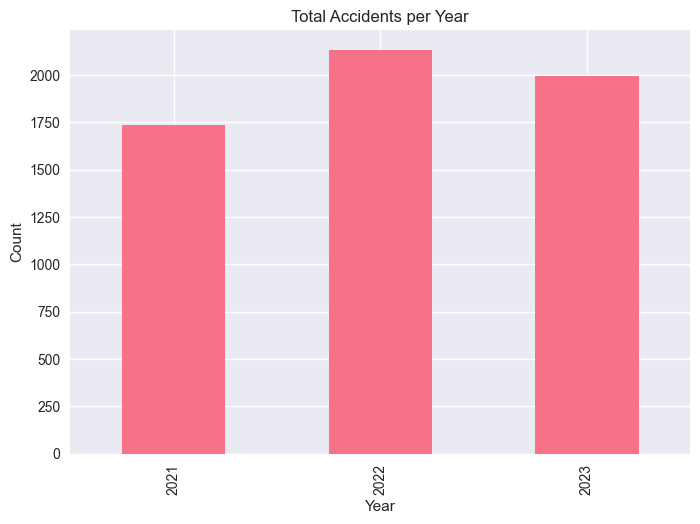

In [83]:
year_counts = gdf_ams["accident_year"].value_counts().sort_index()
year_counts.plot.bar()
plt.title("Total Accidents per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


## Relation with Conditions
3.1 Light Conditions

3.2 Street Lighting

3.3 Weather Conditions

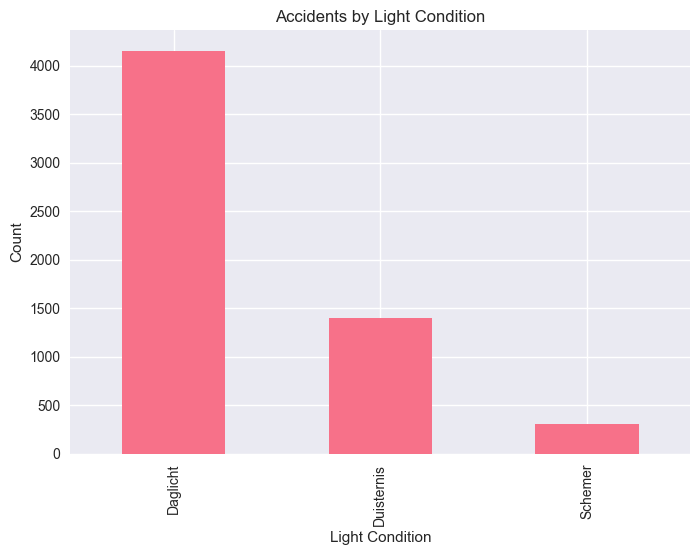

In [85]:
#Lighting condition effect 
lc = gdf_ams["light_condition"].value_counts(ascending=False)
lc.plot.bar()
plt.title("Accidents by Light Condition")
plt.xlabel("Light Condition")
plt.ylabel("Count")
plt.show()

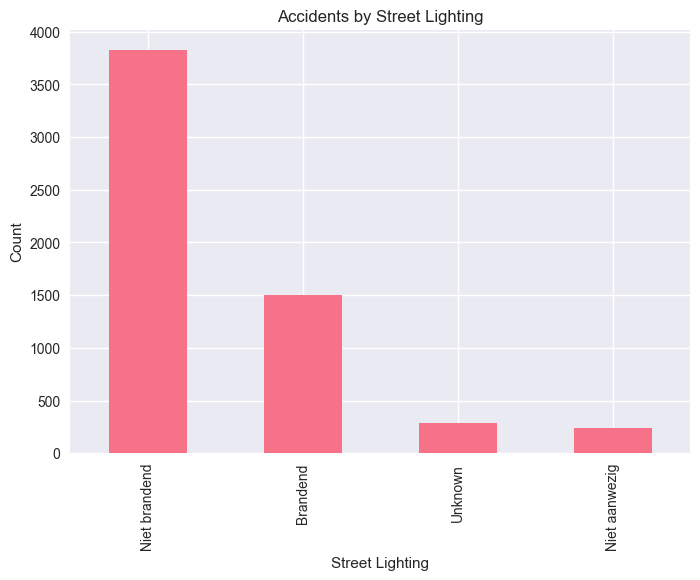

In [87]:
#Street lighting 
sl = gdf_ams["street_lighting"].value_counts(ascending=False)
sl.plot.bar()
plt.title("Accidents by Street Lighting")
plt.xlabel("Street Lighting")
plt.ylabel("Count")
plt.show()


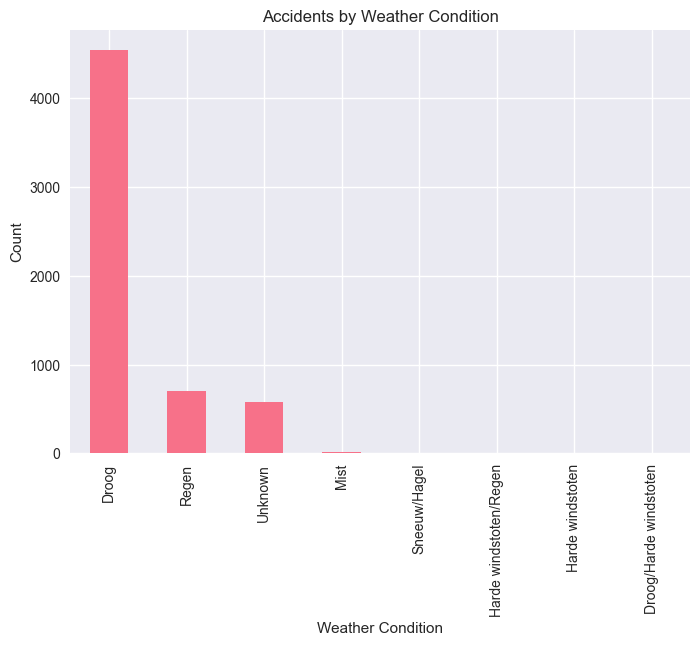

In [58]:
#weather conditions
wc = gdf_ams["weather_condition"].value_counts()
wc.plot.bar()
plt.title("Accidents by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.show()


### 4. Top Streets & Surfaces
- 4.1.  Streets with Most Accidents
- 4.2.  Road Surface Types
### 5. Accident Nature (Cause)
### 6. Multi-factor Pivot Tables 


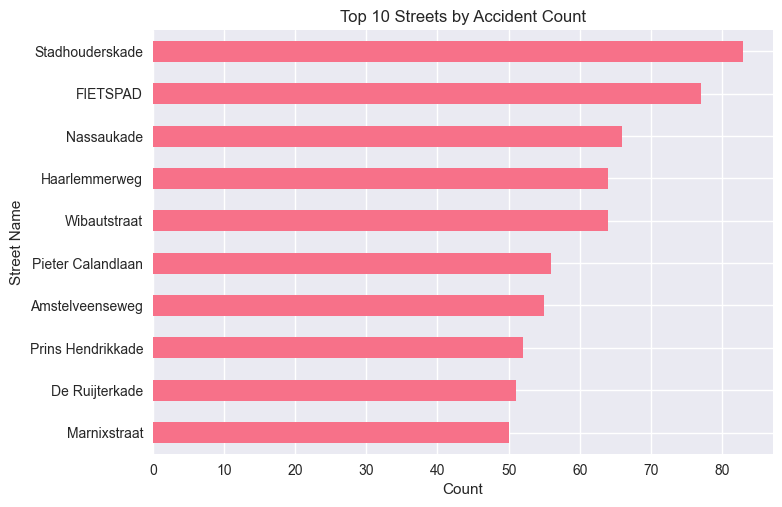

In [73]:
#Street with most accident happened
top_streets = gdf_ams["street_name"].value_counts().head(10)
top_streets.plot.barh()
plt.title("Top 10 Streets by Accident Count")
plt.xlabel("Count")
plt.ylabel("Street Name")
plt.gca().invert_yaxis()
plt.show()


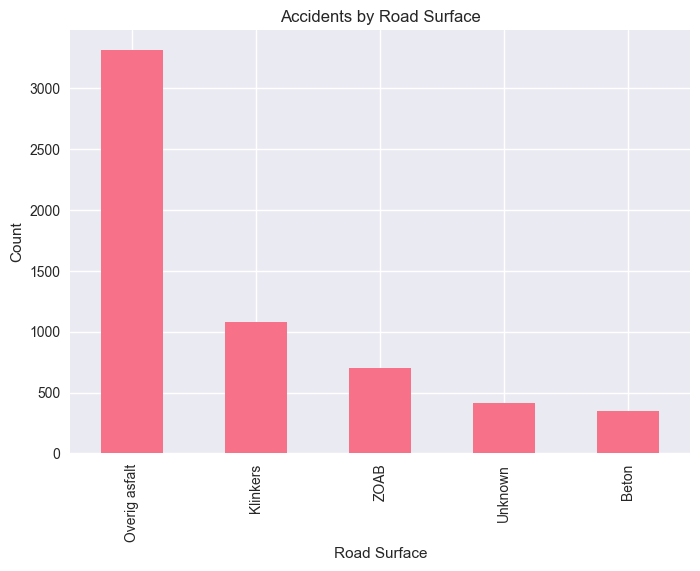

In [75]:
#Road surface
rs = gdf_ams["road_surface"].value_counts()
rs.plot.bar()
plt.title("Accidents by Road Surface")
plt.xlabel("Road Surface")
plt.ylabel("Count")
plt.show()


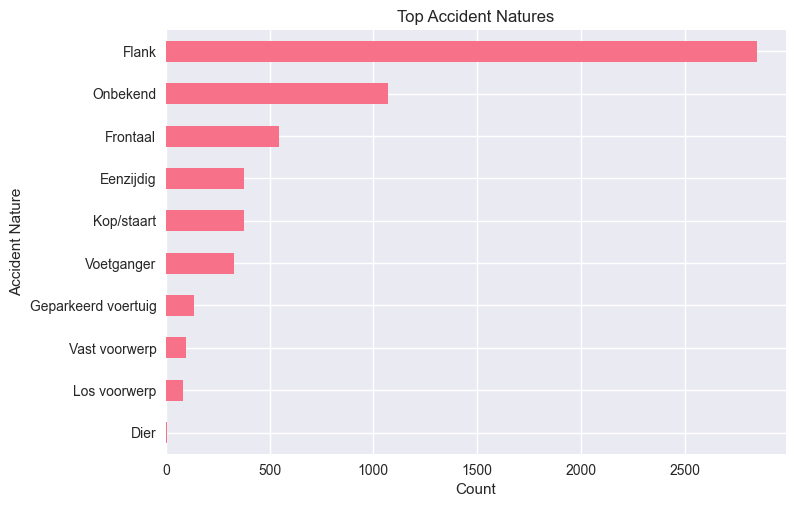

In [77]:
#Accident cause
an = gdf_ams["accident_nature"].value_counts().head(10)
an.plot.barh()
plt.title("Top Accident Natures")
plt.xlabel("Count")
plt.ylabel("Accident Nature")
plt.gca().invert_yaxis()
plt.show()


In [105]:
#Multi-factor Pivot Tables 
pivot = (gdf_ams.pivot_table(
        index="light_condition",
        columns="weather_condition",
        aggfunc="size",
        fill_value=0
    )
    # sort rows and columns in descending alphabetical (or change axis=0↔1 as needed)
    .sort_index(axis=0, ascending=True)
    .sort_index(axis=1, ascending=True)
)

# Display the pivot
display(pivot)


weather_condition  Droog  Droog/Harde windstoten  Harde windstoten  \
light_condition                                                      
Daglicht            3315                       2                 3   
Duisternis          1009                       0                 0   
Schemer              216                       0                 1   

weather_condition  Harde windstoten/Regen  Mist  Regen  Sneeuw/Hagel  Unknown  
light_condition                                                                
Daglicht                                5     5    421             3      403  
Duisternis                              0     8    237             4      140  
Schemer                                 0     2     47             0       37

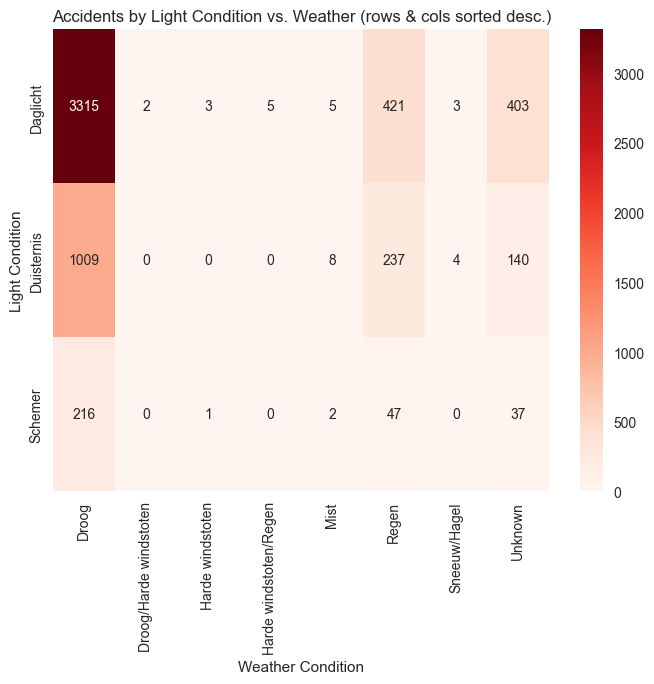

In [103]:
#Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="Reds")
plt.title("Accidents by Light Condition vs. Weather (rows & cols sorted desc.)")
plt.xlabel("Weather Condition")
plt.ylabel("Light Condition")
plt.show()
